In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VARMAX
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

[*********************100%***********************]  2 of 2 completed
C:\Users\AB92922\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Columns in DataFrame: Index(['AAPL', 'MSFT'], dtype='object')
Len: (1006, 2)
Training Size: 805
Train data length: (805, 2)
Test data length: (201, 2)
                                Statespace Model Results                                
Dep. Variable:     ['AAPL_Price', 'MSFT_Price']   No. Observations:                  805
Model:                               VARMA(1,1)   Log Likelihood                4458.792
                                    + intercept   AIC                          -8891.584
Date:                          Thu, 19 Sep 2024   BIC                          -8830.603
Time:                                  19:39:11   HQIC                         -8868.164
Sample:                              01-02-2020                                         
                                   - 03-16-2022                                         
Covariance Type:                            opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jar

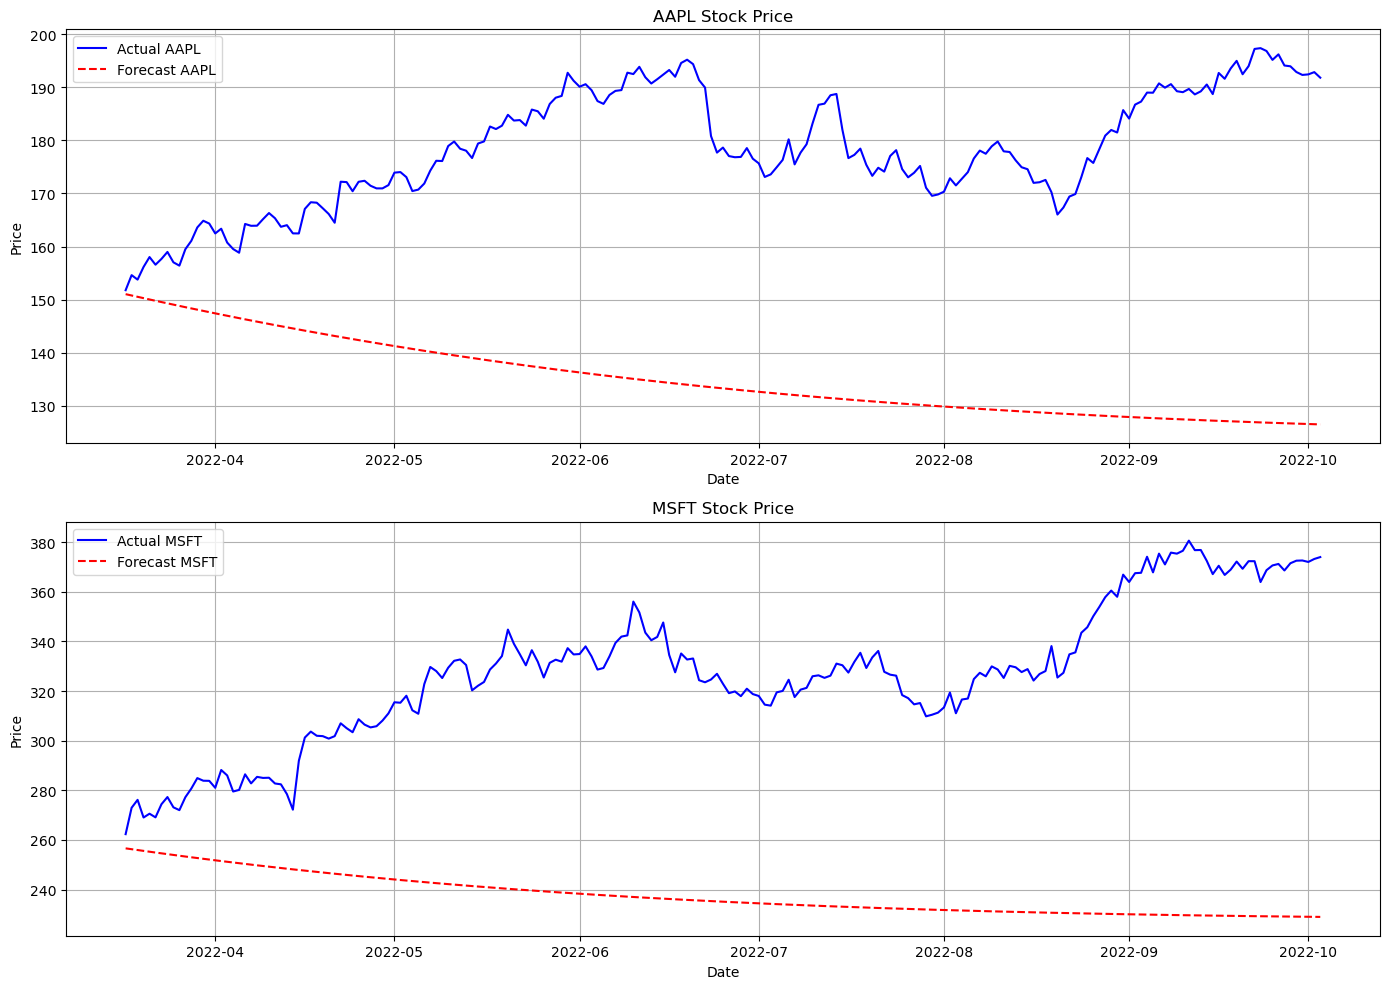

In [2]:
# Load your data
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close']
data.columns = ['AAPL', 'MSFT']  # Rename columns for consistency

# Print column names to verify
print("Columns in DataFrame:", data.columns)

# Ensure data has proper frequency
data.index = pd.date_range(start=data.index[0], periods=len(data), freq='D')

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['AAPL', 'MSFT']])
data_scaled_df = pd.DataFrame(data_scaled, columns=['AAPL_Price', 'MSFT_Price'], index=data.index)

print("Len:", data_scaled.shape)

# Split data into train and test sets
training_size = round(len(data_scaled) * 0.80)
print("Training Size:", training_size)

train_data = data_scaled_df.iloc[:training_size]
test_data = data_scaled_df.iloc[training_size:]

print("Train data length:", train_data.shape)
print("Test data length:", test_data.shape)

# Fit VARMAX model using VARMAX
try:
    # Define the VARMAX model
    model = VARMAX(train_data, order=(1, 1))  # order=(p, q) for VARMAX
    model_fit = model.fit(disp=False)
    
    # Print model summary
    print(model_fit.summary())
    
    # Predict on test set
    forecast_steps = len(test_data)
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_df = forecast.predicted_mean
    forecast_df.index = test_data.index
    forecast_df.columns = ['AAPL_Price', 'MSFT_Price']

    # Calculate RMSE and MAPE
    rmse_aapl = np.sqrt(((test_data['AAPL_Price'] - forecast_df['AAPL_Price'])**2).mean())
    mape_aapl = (np.abs((test_data['AAPL_Price'] - forecast_df['AAPL_Price']) / test_data['AAPL_Price'])).mean()

    rmse_msft = np.sqrt(((test_data['MSFT_Price'] - forecast_df['MSFT_Price'])**2).mean())
    mape_msft = (np.abs((test_data['MSFT_Price'] - forecast_df['MSFT_Price']) / test_data['MSFT_Price'])).mean()

    print("RMSE-Testset AAPL:", rmse_aapl)
    print("MAPE-Testset AAPL:", mape_aapl)

    print("RMSE-Testset MSFT:", rmse_msft)
    print("MAPE-Testset MSFT:", mape_msft)

    # Inverse transform forecast to original scale
    forecast_inv = scaler.inverse_transform(forecast_df[['AAPL_Price', 'MSFT_Price']])
    forecast_inv_df = pd.DataFrame(forecast_inv, columns=['AAPL', 'MSFT'], index=forecast_df.index)

    # Inverse transform test data to original scale
    test_data_inv = scaler.inverse_transform(test_data[['AAPL_Price', 'MSFT_Price']])
    test_data_inv_df = pd.DataFrame(test_data_inv, columns=['AAPL', 'MSFT'], index=test_data.index)

    # Plot actual vs forecasted values
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    plt.plot(test_data_inv_df.index, test_data_inv_df['AAPL'], label='Actual AAPL', color='blue')
    plt.plot(forecast_inv_df.index, forecast_inv_df['AAPL'], label='Forecast AAPL', color='red', linestyle='--')
    plt.title('AAPL Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(test_data_inv_df.index, test_data_inv_df['MSFT'], label='Actual MSFT', color='blue')
    plt.plot(forecast_inv_df.index, forecast_inv_df['MSFT'], label='Forecast MSFT', color='red', linestyle='--')
    plt.title('MSFT Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save forecast to CSV
    forecast_inv_df.to_csv("StockPriceForecast_VARMAX.csv", index=True)

except Exception as e:
    print(f"An error occurred: {e}")